### Cost functions
They describe the goal of the problem, and how well a trial state is performing with respect to that goal.

In [6]:
def cost_func_vqe(params, circuit, hamiltonian, estimator):
    pub = (circuit, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs

    return cost

In [7]:
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import SparsePauliOp
from qiskit import QuantumCircuit

observable = SparsePauliOp.from_list([("XX", 1), ("YY", -3)])
reference_circuit = QuantumCircuit(2)
reference_circuit.x(0)

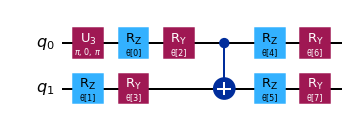

In [8]:
import numpy as np

variational_form = TwoLocal(
    num_qubits=2,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1
)

ansatz = reference_circuit.compose(variational_form)

theta_list = (2 * np.pi * np.random.rand(1,8)).tolist()
ansatz.decompose().draw('mpl')

In [9]:
from qiskit.primitives import StatevectorEstimator
estimator = StatevectorEstimator()
cost = cost_func_vqe(theta_list, ansatz, observable, estimator)
print(cost)

[-2.26692243]


In [10]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, EstimatorV2 as Estimator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational = True, min_num_qubits=ansatz.num_qubits, simulator = False)


pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_ansatz = pm.run(ansatz)
isa_observable = observable.apply_layout(layout=isa_ansatz.layout)


In [11]:
session = Session(backend = backend)
estimator = Estimator(session)
cost = cost_func_vqe(theta_list, isa_ansatz, isa_observable, estimator)

session.close()
print(cost)


[-2.34994337]


We can observe from above that the values obtained on a simulator and on a real quantum computer are very similar

### Max-Cut

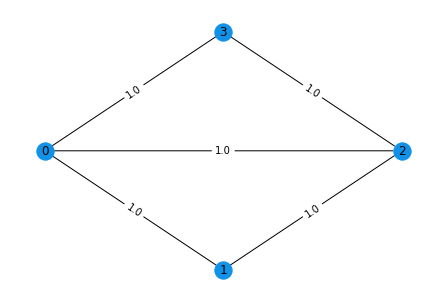

In [12]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw

n = 4
G = rx.PyGraph()
G.add_nodes_from(range(n))
edges = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0)]
G.add_edges_from(edges)

mpl_draw(G, pos=rx.shell_layout(G), with_labels=True, edge_labels=str, node_color="#1192E8")

In [13]:
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp

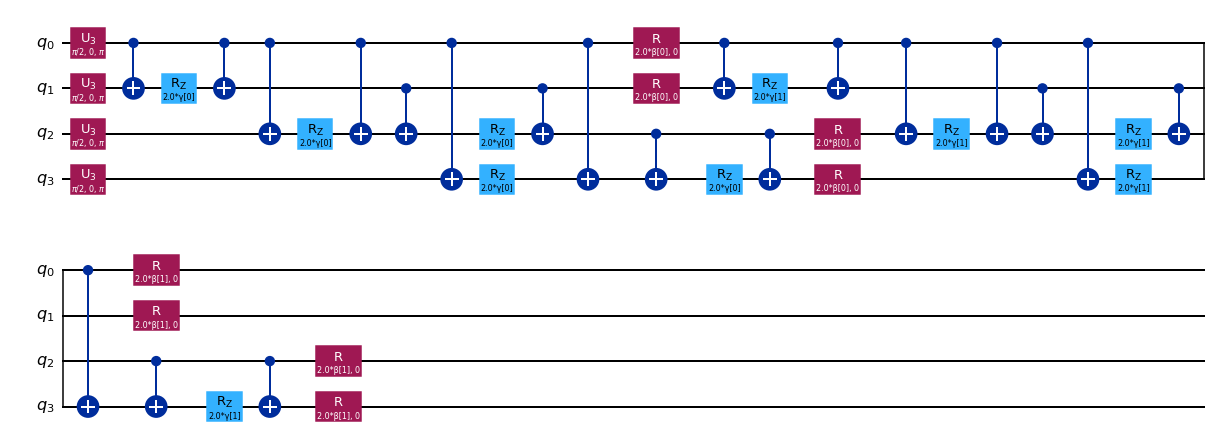

In [14]:
#Add z gate on each node connected by an edge

hamiltonian = SparsePauliOp.from_list([("IIZZ", 1), ("IZIZ", 1), ("IZZI", 1), ("ZIIZ", 1), ("ZZII", 1)
])

ansatz = QAOAAnsatz(hamiltonian, reps=2)
ansatz.decompose(reps=3).draw("mpl")

In [15]:
# offset is the sum of the weights of the edges divided by 2

offset = -sum(edge[2] for edge in edges) / 2
print(f"Offset is : {offset}")

Offset is : -2.5


In [16]:
def cost_func(params, ansatz, hamiltonian, estimator):
    pub = (ansatz, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs
    return cost

In [17]:
import numpy as np
x0 = 2 * np.pi * np.random.rand(ansatz.num_parameters)

estimator = StatevectorEstimator()
cost = cost_func(x0, ansatz, hamiltonian, estimator)
print(cost)

-1.4048094842183787


In [19]:
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational = True, min_num_qubits=ansatz.num_qubits, simulator = False)

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_ansatz = pm.run(ansatz)
isa_observable = hamiltonian.apply_layout(layout=isa_ansatz.layout)


In [20]:
session = Session(backend = backend)
estimator = Estimator(session)
cost = cost_func(x0, isa_ansatz, isa_observable, estimator)

session.close()
print(cost)


0.40190670613571267
